# **Preliminary Data Analysis on Uber Pickups in NYC**

In [ ]:
pip install basemap basemap-data-hires

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


Importing necessary packages:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, json
import folium
from folium.plugins import HeatMap
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
from mpl_toolkits.basemap import Basemap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from IPython.display import IFrame
import os
import gc

In [ ]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading in data:

In [ ]:
# Collecting data from google drive
months_14 = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/I_Xperience2024-2-Uber-Ride-Analysis/data'):
    for filename in filenames:
        if filename.startswith('uber-raw') and filename.endswith('14.csv'):
            globals()[filename[14:18]] = pd.read_csv(os.path.join(dirname, filename))
            months_14.append(globals()[filename[14:18]])

# Concatenating 2014 april to september monthly data
aprsep_14 = pd.concat(months_14)

# Removing filenames from memory to free up space.
for filename in filenames:
    if filename.startswith('uber-raw') and filename.endswith('14.csv'):
      del globals()[filename[14:18]]
gc.collect()

# EDA (Commented) Uncomment as needed
# print(aprsep_14.shape)
# print(aprsep_14.head())
# print(aprsep_14.describe())
# print(aprsep_14.dtypes)

0


---

**Cleaning the 2014 dataset:**

Removing duplicate data:

In [ ]:
# Should be (4534327, 4)
print(aprsep_14.shape)

duplicate_rows_aprsep_14 = aprsep_14[aprsep_14.duplicated()]

# Should be (82581, 4)
print(duplicate_rows_aprsep_14.shape)

aprsep_14 = aprsep_14.drop_duplicates(keep='first')

# Should be (4451746, 4)
print(aprsep_14.shape)

(4534327, 4)
(82581, 4)
(4451746, 4)


In [ ]:
# Renaming column titles
aprsep_14 = aprsep_14.rename(columns={"Date/Time":"date_time"})
aprsep_14 = aprsep_14.rename(columns={"Lat":"lat"})
aprsep_14 = aprsep_14.rename(columns={"Lon":"lon"})
aprsep_14 = aprsep_14.rename(columns={"Base":"base"})

# Changing date_time column data type to datetime
aprsep_14["date_time"] = pd.to_datetime(aprsep_14["date_time"])

# Should be: Index(['date_time', 'lat', 'lon', 'base'], dtype='object')
print(aprsep_14.columns, "\n")

'''Should be: date_time    datetime64[ns]
              lat          float64
              lon          float64
              base          object
              dtype: object'''
print(aprsep_14.dtypes)

Index(['date_time', 'lat', 'lon', 'base'], dtype='object') 

date_time    datetime64[ns]
lat                 float64
lon                 float64
base                 object
dtype: object


In [ ]:
# Feature engineering more columns
aprsep_14['month'] = aprsep_14['date_time'].dt.month_name()
aprsep_14['weekday'] = aprsep_14['date_time'].dt.day_name()
aprsep_14['day'] = aprsep_14['date_time'].dt.day
aprsep_14['hour'] = aprsep_14['date_time'].dt.hour
aprsep_14['minute'] = aprsep_14['date_time'].dt.minute

aprsep_14.describe()

,date_time,lat,lon,day,hour,minute
count,4451746,4.451746e+06,4.451746e+06,4.451746e+06,4.451746e+06,4.451746e+06
mean,2014-07-11 14:44:15.403250176,4.073924e+01,-7.397304e+01,1.593756e+01,1.421754e+01,2.940101e+01
min,2014-04-01 00:00:00,3.965690e+01,-7.492900e+01,1.000000e+00,0.000000e+00,0.000000e+00
25%,2014-05-28 10:32:00,4.072110e+01,-7.399650e+01,9.000000e+00,1.000000e+01,1.400000e+01
50%,2014-07-17 09:28:00,4.074220e+01,-7.398340e+01,1.600000e+01,1.500000e+01,2.900000e+01
75%,2014-08-27 18:47:00,4.076100e+01,-7.396530e+01,2.300000e+01,1.900000e+01,4.400000e+01
max,2014-09-30 22:59:00,4.211660e+01,-7.206660e+01,3.100000e+01,2.300000e+01,5.900000e+01
std,NaN,3.984343e-02,5.721967e-02,8.745713e+00,5.957576e+00,1.732251e+01


In [ ]:
# Should be all 0s
print(aprsep_14.isnull().sum())

date_time    0
lat          0
lon          0
base         0
month        0
weekday      0
day          0
hour         0
minute       0
dtype: int64


---

# **Standard dataset final definitions**

Please do not change aprsep_14 from here on. Rather use MyVar = aprsep_14.copy()

In [ ]:
# Classify each ride as "Rush Hour" or "Non-Rush Hour"
def classify_rush_hour(hour):
    if 7 <= hour <= 9 or 16 <= hour <= 19:
        return 'Rush Hour'
    else:
        return 'Non-Rush Hour'

aprsep_14['rush_hour'] = aprsep_14['hour'].apply(classify_rush_hour)

# Create a count column
aprsep_14['count'] = 1

# Sort by date_time
aprsep_14 = aprsep_14.sort_values(by='date_time')

aprsep_14.head()

,date_time,lat,lon,base,month,weekday,day,hour,minute,rush_hour,count
326800,2014-04-01 00:00:00,40.7215,-73.9952,B02682,April,Tuesday,1,0,0,Non-Rush Hour,1
35536,2014-04-01 00:00:00,40.7637,-73.9600,B02598,April,Tuesday,1,0,0,Non-Rush Hour,1
35537,2014-04-01 00:00:00,40.7188,-73.9863,B02598,April,Tuesday,1,0,0,Non-Rush Hour,1
218799,2014-04-01 00:01:00,40.7355,-73.9966,B02617,April,Tuesday,1,0,1,Non-Rush Hour,1
35538,2014-04-01 00:02:00,40.7444,-73.9964,B02598,April,Tuesday,1,0,2,Non-Rush Hour,1


In [ ]:
aprsep_14.to_pickle('/content/drive/My Drive/I_Xperience2024-2-Uber-Ride-Analysis/data/aprsep_14.pkl')

In [ ]:
aprsep_14.tail()

,date_time,lat,lon,base,month,weekday,day,hour,minute,rush_hour,count
652659,2014-09-30 22:59:00,40.6771,-73.9521,B02617,September,Tuesday,30,22,59,Non-Rush Hour,1
652660,2014-09-30 22:59:00,40.7794,-73.9555,B02617,September,Tuesday,30,22,59,Non-Rush Hour,1
652661,2014-09-30 22:59:00,40.7410,-74.0018,B02617,September,Tuesday,30,22,59,Non-Rush Hour,1
652658,2014-09-30 22:59:00,40.7819,-73.9490,B02617,September,Tuesday,30,22,59,Non-Rush Hour,1
652662,2014-09-30 22:59:00,40.6988,-73.9174,B02617,September,Tuesday,30,22,59,Non-Rush Hour,1




---


# **DATA VISUALIZATION**

In [ ]:
# sampling 5% of data for quicker rendering if necessary.
aprsep_14_sample = aprsep_14.sample(frac=0.05)

Text(0.5, 1.0, 'Rides per Month (April - September)')

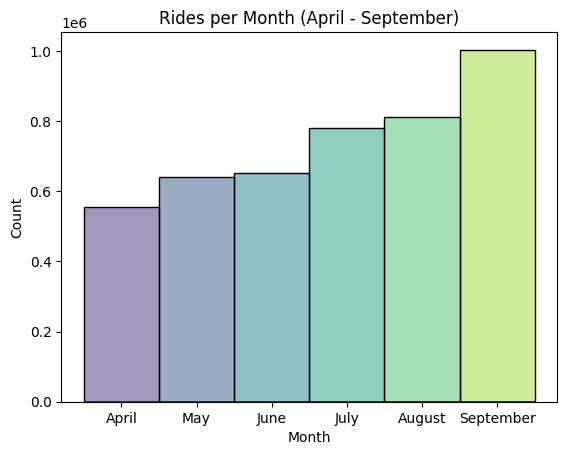

In [ ]:
ax = sns.histplot(data=aprsep_14, x='month', hue='month', palette="viridis", legend=False)
ax.set(xlabel='Month', ylabel='Count')
ax.set_title("Rides per Month (April - September)")

Text(0.5, 1.0, 'Rides per Day of the Week (Monday - Sunday)')

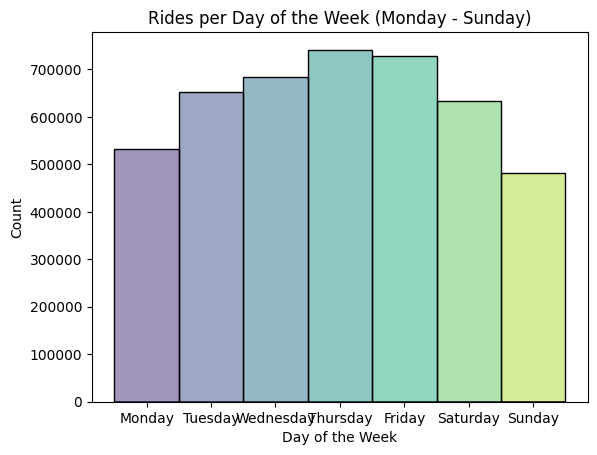

In [ ]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
temp = aprsep_14.copy()
temp['weekday'] = pd.Categorical(temp['weekday'], categories=weekday_order, ordered=True)

bx = sns.histplot(data=temp, x='weekday', hue='weekday', palette="viridis", legend=False)
bx.set(xlabel='Day of the Week', ylabel='Count')
bx.set_title("Rides per Day of the Week (Monday - Sunday)")

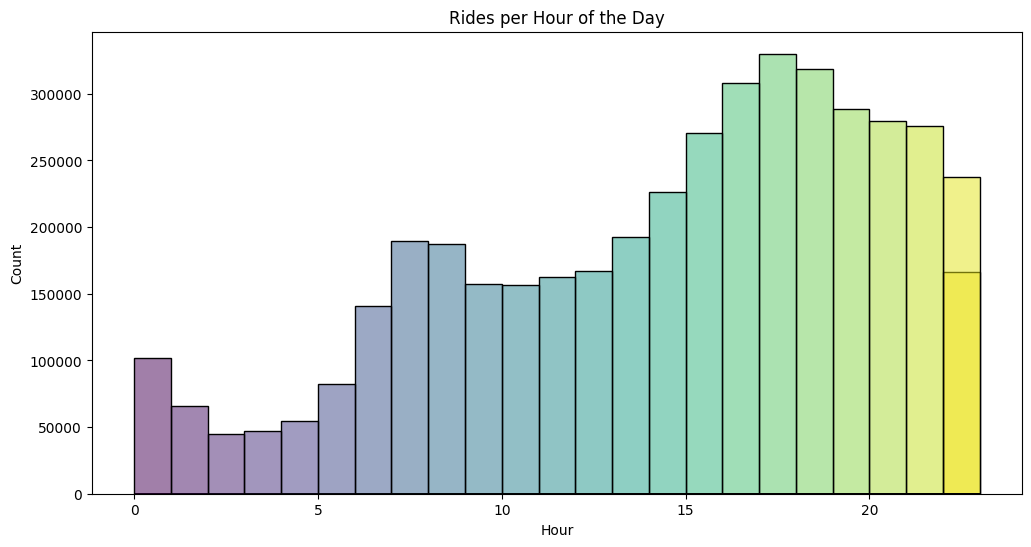

In [ ]:
temp = aprsep_14.sort_values(by='hour')
plt.figure(figsize=(12, 6))
cx = sns.histplot(data=temp, x='hour', hue='hour', palette="viridis", legend=False, binwidth=1)
cx.set(xlabel='Hour', ylabel='Count')
cx.set_title("Rides per Hour of the Day")
plt.show()

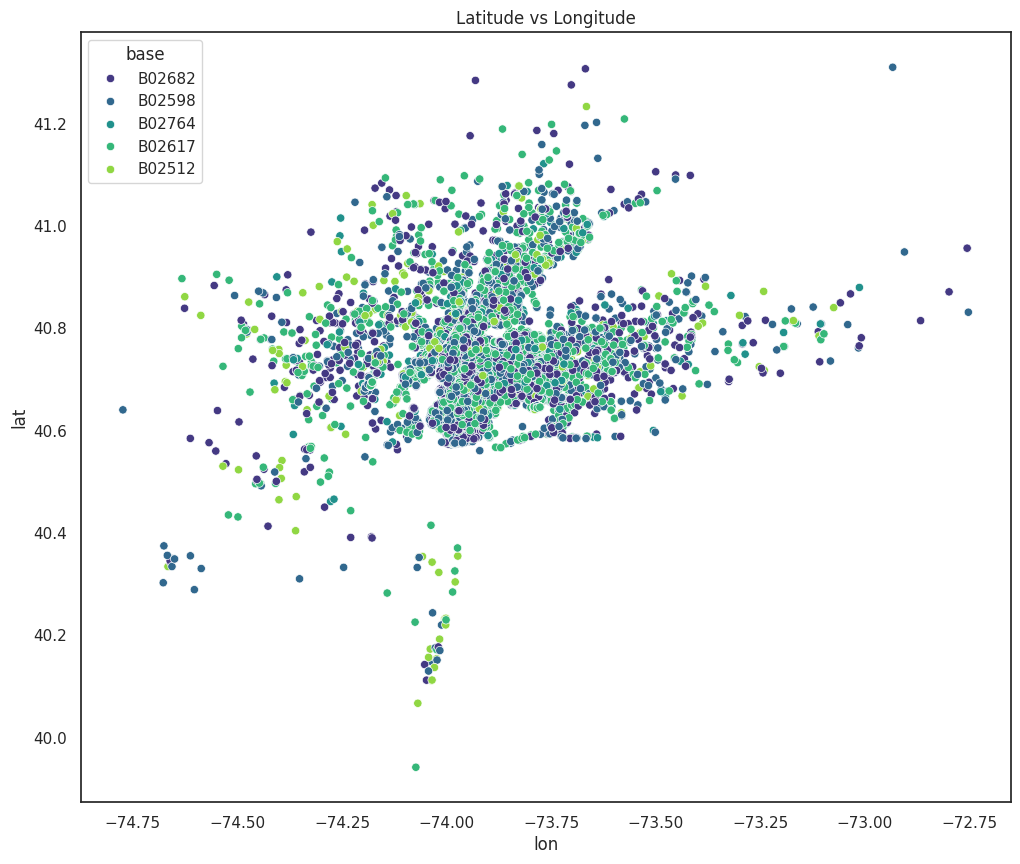

In [ ]:
# Scatterplot with longitude and latitude, hue by base
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(x="lon", y="lat", hue="base", data=aprsep_14_sample, palette="viridis")
plt.title('Latitude vs Longitude')
plt.show()
plt.close()

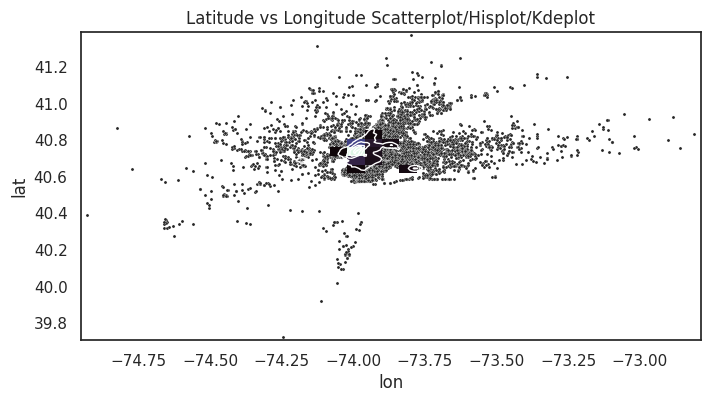

In [ ]:
# Combined scatterplot, histplot, and kdeplot
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(x="lon", y="lat", s=5, color=".15", data=aprsep_14_sample)
sns.histplot(x="lon", y="lat", bins=35, pthresh=.05, cmap="mako", data=aprsep_14_sample)
sns.kdeplot(x="lon", y="lat", levels=5, color="w", linewidths=1, data=aprsep_14_sample)
plt.title('Latitude vs Longitude Scatterplot/Hisplot/Kdeplot')
plt.show()
plt.close()

In [ ]:
# Interactive heatmap overlayed on US map
def update_heatmap(hour, day_of_week, month):
    filtered_data = aprsep_14_sample[(aprsep_14_sample['hour'] == hour) & (aprsep_14_sample['weekday'] == day_of_week) & (aprsep_14_sample['month'] == month)]
    heat_data = [[row['lat'], row['lon']] for index, row in filtered_data.iterrows()]
    nyc_map = folium.Map(location=[40.7831, -73.9712], zoom_start=10)
    HeatMap(heat_data, opacity = 0.2).add_to(nyc_map)

    return nyc_map

month_dropdown = widgets.Dropdown(options=['April', 'May', 'June', 'July', 'August', 'September'], value='April', description='Month:')
day_dropdown = widgets.Dropdown(options=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], value='Monday', description='Day of Week:')
hour_slider = widgets.IntSlider(min=0, max=23, step=1, value=12, description='Hour:')

interact(update_heatmap, hour=hour_slider, day_of_week=day_dropdown, month=month_dropdown)

interactive(children=(IntSlider(value=12, description='Hour:', max=23), Dropdown(description='Day of Week:', o…

<function __main__.update_heatmap(hour, day_of_week, month)>

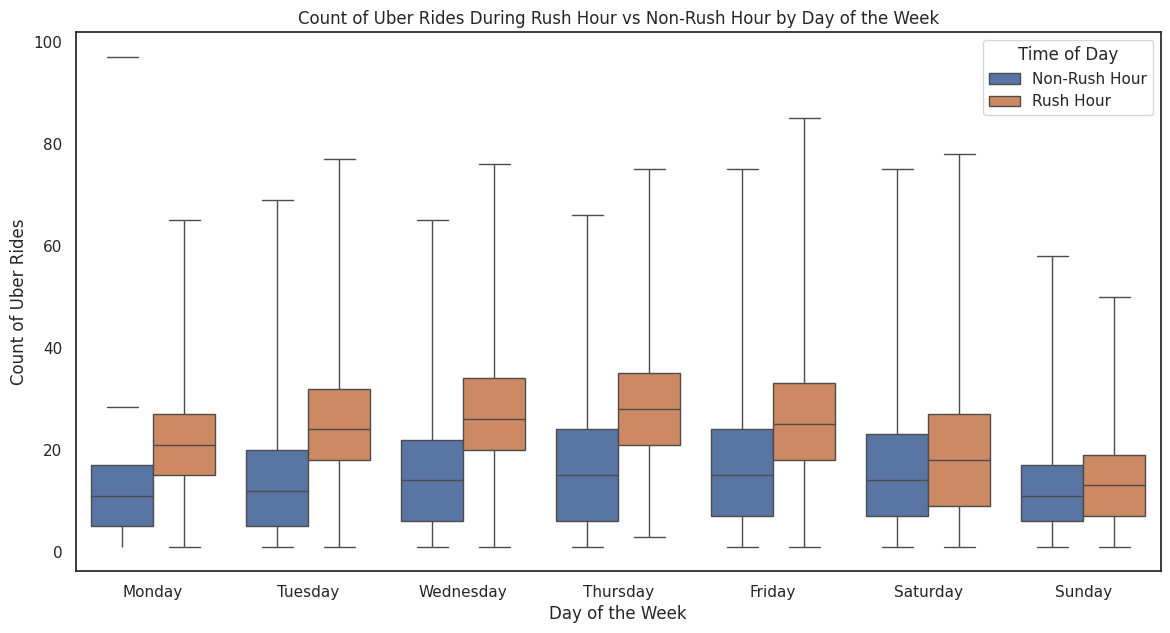

In [ ]:
BoxPlotData = aprsep_14.groupby(['date_time','weekday', 'rush_hour']).size().reset_index(name='count')

# Create count plots
plt.figure(figsize=(14, 7))
sns.boxplot(x='weekday', y=BoxPlotData["count"] , hue='rush_hour', data=BoxPlotData,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            whis = [0, 100])
plt.gca().lines[1].set_ydata([BoxPlotData["count"].mean() - BoxPlotData["count"].std(),
                              BoxPlotData["count"].mean() - BoxPlotData["count"].std()])
plt.gca().lines[2].set_ydata([BoxPlotData["count"].mean() + BoxPlotData["count"].std(),
                              BoxPlotData["count"].mean() + BoxPlotData["count"].std()])
plt.title('Count of Uber Rides During Rush Hour vs Non-Rush Hour by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count of Uber Rides')
plt.legend(title='Time of Day')
plt.show()
plt.close()

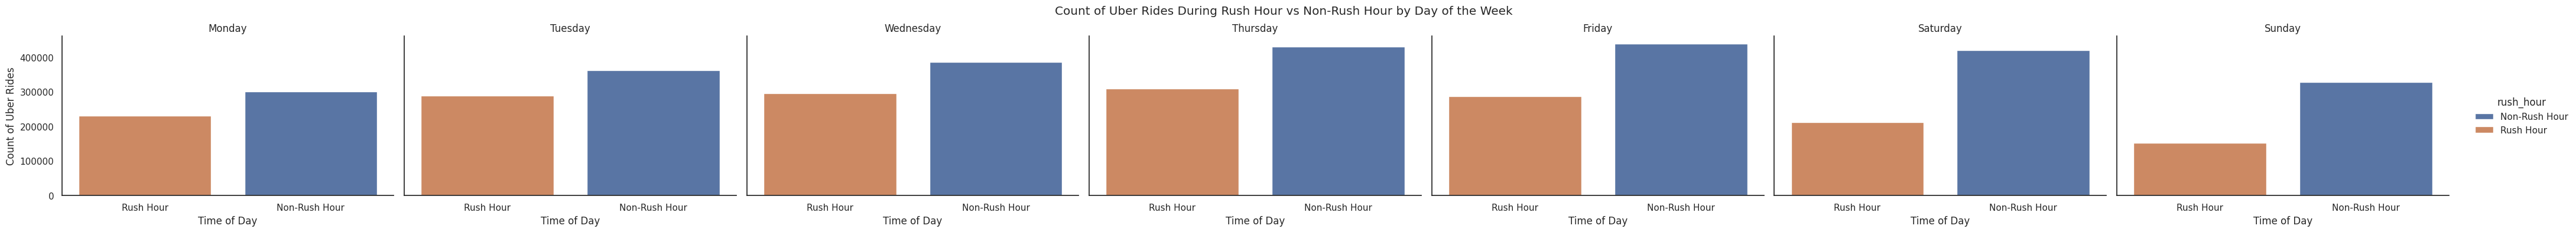

In [ ]:
# Create a FacetGrid
g = sns.FacetGrid(aprsep_14, col='weekday', col_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], hue='rush_hour', height=4, aspect=1.5)
g.map(sns.countplot, 'rush_hour', order=['Rush Hour', 'Non-Rush Hour'])
g.add_legend()
g.set_titles("{col_name}")
g.set_axis_labels("Time of Day", "Count of Uber Rides")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Count of Uber Rides During Rush Hour vs Non-Rush Hour by Day of the Week')
plt.show()
plt.close()

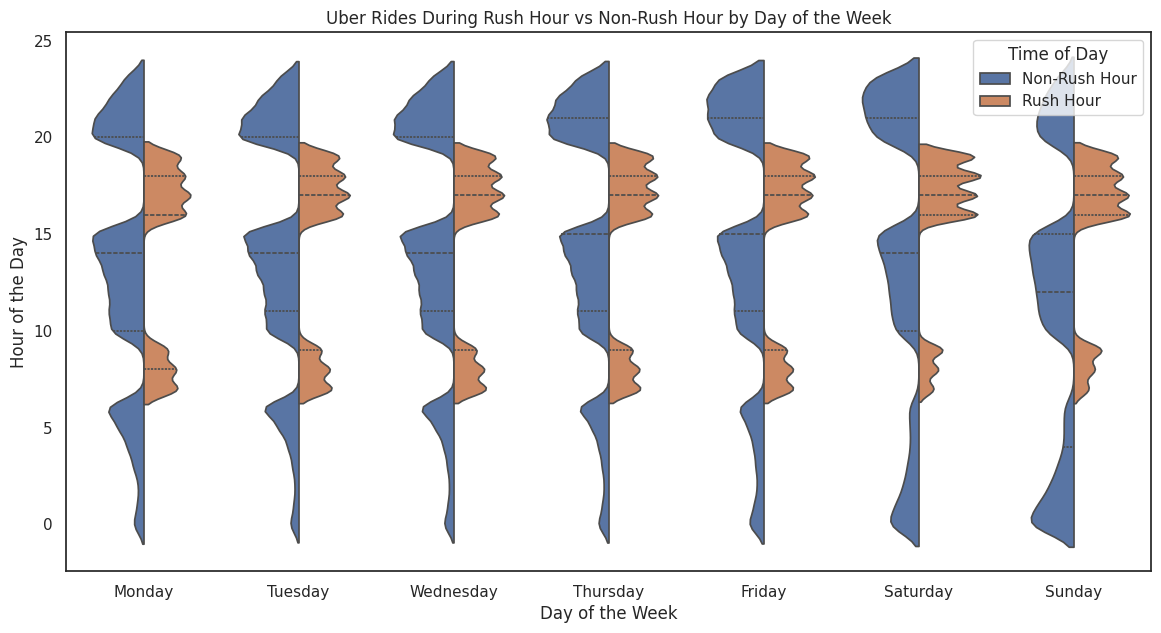

In [ ]:
# Create violin plots
plt.figure(figsize=(14, 7))
sns.violinplot(x='weekday', y='hour', hue='rush_hour', data=aprsep_14, split=True, inner="quart", order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Uber Rides During Rush Hour vs Non-Rush Hour by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.legend(title='Time of Day')
plt.show() #ADD A COLUMN RIDES PER HOUR
plt.close()

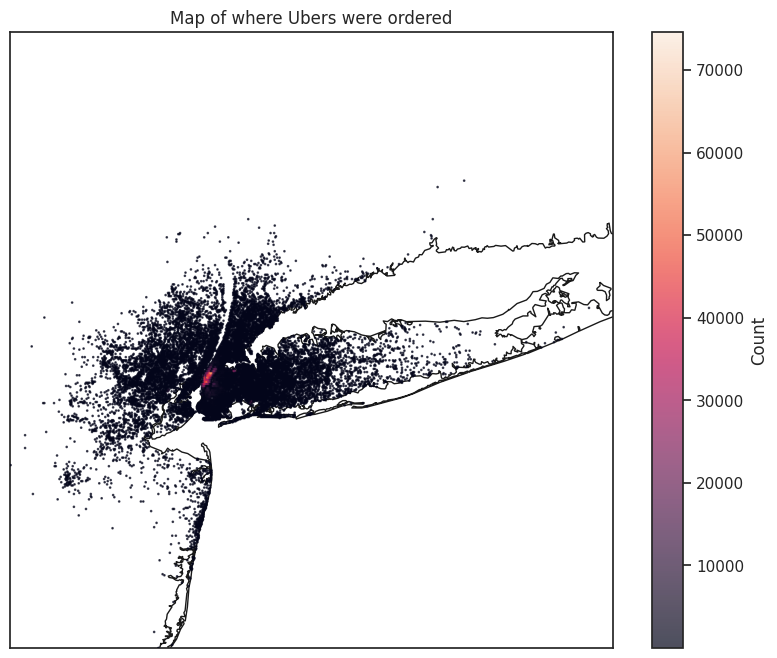

In [ ]:
# Create a figure and add a Basemap instance
fig = plt.figure(figsize=(10, 8))

# Create a Basemap instance for the whole world
m = Basemap(projection='mill', llcrnrlat=aprsep_14["lat"].min(), urcrnrlat=aprsep_14["lat"].max(),
            llcrnrlon=aprsep_14["lon"].min(), urcrnrlon=aprsep_14["lon"].max(), resolution='h')

# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()

x, y = m(aprsep_14["lon"], aprsep_14["lat"])
m.hexbin(x, y, gridsize = 500, zorder=5, mincnt = 1, alpha = 0.7)
plt.colorbar(label='Count')
plt.title('Map of where Ubers were ordered')
plt.show()
plt.close()

In [ ]:
random_forest_data = aprsep_14.copy()

weekday_to_float = {
    'Monday' : 1.0,
    'Tuesday' : 2.0,
    'Wednesday' : 3.0,
    'Thursday' : 4.0,
    'Friday' : 5.0,
    'Saturday' : 6.0,
    'Sunday' : 7.0,
}

month_to_float = {
    'April' : 1.0,
    'May' : 2.0,
    'June' : 3.0,
    'July' : 4.0,
    'August' : 5.0,
    'September' : 6.0,
}

random_forest_data["weekday"] = random_forest_data["weekday"].map(weekday_to_float)
random_forest_data["month"] = random_forest_data["month"].map(month_to_float)
random_forest_data.head()

,date_time,lat,lon,base,month,weekday,day,hour,minute,rush_hour,count
35537,2014-04-01 00:00:00,40.7188,-73.9863,B02598,1.0,2.0,1,0,0,Non-Rush Hour,1
35536,2014-04-01 00:00:00,40.7637,-73.9600,B02598,1.0,2.0,1,0,0,Non-Rush Hour,1
326800,2014-04-01 00:00:00,40.7215,-73.9952,B02682,1.0,2.0,1,0,0,Non-Rush Hour,1
218799,2014-04-01 00:01:00,40.7355,-73.9966,B02617,1.0,2.0,1,0,1,Non-Rush Hour,1
35539,2014-04-01 00:02:00,40.7556,-73.9874,B02598,1.0,2.0,1,0,2,Non-Rush Hour,1


---
# Random Forest regression to predict Uber requirements by time of day

Trying to fit a linear regression to the date time and location to predict the amount of cars that would be necessary in that area at that time.

In [ ]:
# Making a new dataset that groups by location.

def LocationGroupingFunction(DataFrame, Latitude:str, Longitude:str, DivPerDim:int = 10):
  LocationGroup:list = []

  LatitudeMax = DataFrame[Latitude].max()
  LatitudeMin = DataFrame[Latitude].min()
  LongitudeMax = DataFrame[Longitude].max()
  LongitudeMin = DataFrame[Longitude].min()

  LatitudeRange = (LatitudeMax - LatitudeMin)
  LongitudeRange = (LongitudeMax - LongitudeMin)
  LatitudeDivisionSize = LatitudeRange / DivPerDim
  LongitudeDivisionSize = LongitudeRange / DivPerDim

  for Lat, Lon in zip(DataFrame[Latitude],DataFrame[Longitude]):
    LatVal = abs(math.floor(float(Lat - LatitudeMin)/LatitudeDivisionSize))
    LonVal = abs(math.floor(float(Lon - LongitudeMin)/LongitudeDivisionSize))
    LocationGroup.append(LatVal*10**math.floor(math.log10(DivPerDim))+LonVal)

  return LocationGroup

In [ ]:
LinearData = aprsep_14.copy()
LinearData["group"] = LocationGroupingFunction(LinearData, "lat", "lon", DivPerDim = 100)
LinearData["date"] = LinearData.date_time.dt.date
LinearData.drop(["lat", "lon", "date_time", 'rush_hour', 'count'], axis = 1, inplace = True)
# LinearData.base, Bases = LinearData.base.factorize()
# LinearData.month, Months = LinearData.month.factorize()
# LinearData.weekday, Weekdays = LinearData.weekday.factorize()
LinearData = LinearData.groupby(["date", "group", 'month', 'day','hour']).size().reset_index(name = "pickups")

In [ ]:
DummyData = pd.get_dummies(LinearData, columns = ['month'])
DummyData.columns

Index(['date', 'group', 'day', 'hour', 'pickups', 'month_April',
       'month_August', 'month_July', 'month_June', 'month_May',
       'month_September'],
      dtype='object')

In [ ]:
Regressor = RandomForestRegressor(n_jobs=-1)

Scaler = StandardScaler()

X = Scaler.fit_transform(DummyData.drop(["pickups", 'date'], axis = 1)[['group', 'day', 'hour']])
X = pd.concat([pd.DataFrame(X, columns = ['group', 'day', 'hour']), DummyData.drop(["pickups", 'date'], axis = 1)[['month_April', 'month_May', 'month_June', 'month_July', 'month_August', 'month_September']]], axis = 1)
Y = LinearData["pickups"]

In [ ]:
Principle = PCA(n_components=9)

PcaScores = pd.DataFrame(Principle.fit_transform(X), columns = ['PC' + str(i) for i in range(1, 10)])

PcaComponents = pd.DataFrame(Principle.components_[0:3], columns = X.columns)
KeepFeatures = PcaComponents.describe().T[PcaComponents.describe().T.abs()['max'] >= 0.5].index

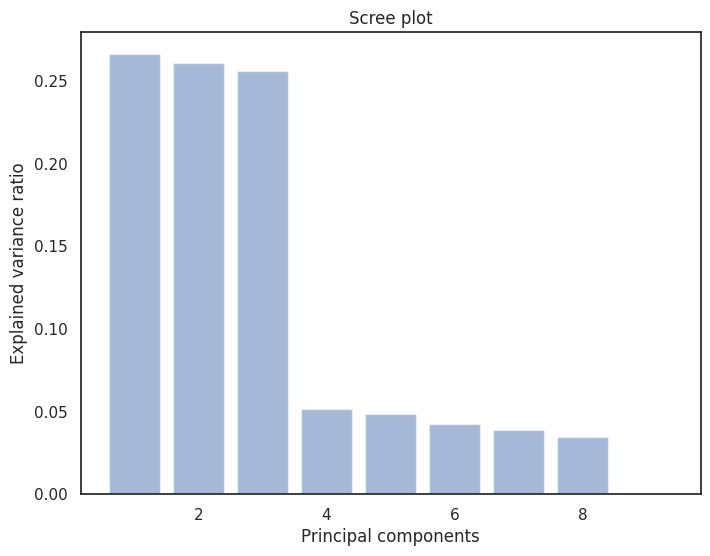

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(Principle.explained_variance_ratio_) + 1), Principle.explained_variance_ratio_, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Scree plot')
plt.show()

In [ ]:
CorrectHours = train_test_split(DummyData.hour, Y, test_size=0.3, random_state=2002)[1]
CorrectDays = train_test_split(DummyData.day, Y, test_size=0.3, random_state=2002)[1]
CorrectMonths = train_test_split(LinearData.month, Y, test_size=0.3, random_state=2002)[1]
CorrectMonths = CorrectMonths.replace({0: 'April', 1: 'May', 2: 'June', 3: 'July', 4: 'August', 5: 'September'})

XTrain, XTest, YTrain, YTest = train_test_split(X[['group', 'day', 'hour', 'month_April', 'month_May', 'month_June', 'month_July', 'month_August', 'month_September']], Y, test_size=0.3, random_state=2002)

Regressor.fit(XTrain, YTrain)

RandomForestRegressor(n_jobs=-1)

In [ ]:
PredictedRequirements = Regressor.predict(XTest)

print(r2_score(YTest, PredictedRequirements))
# len(PredictedRequirements)

0.9090988205765662


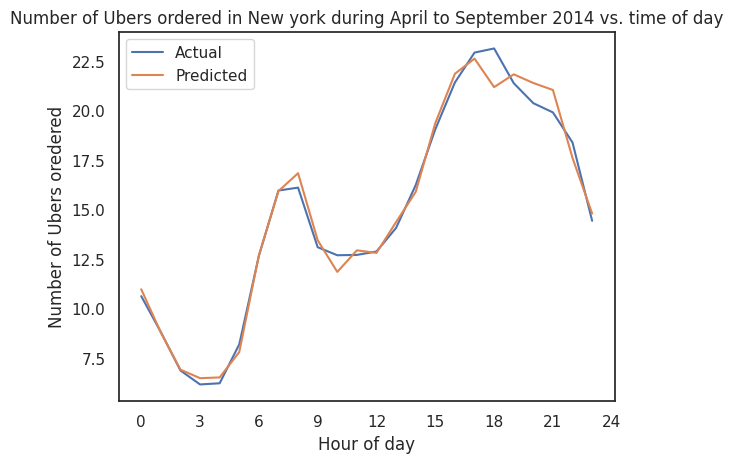

In [ ]:
#Ploting the Actual data against the predictive data.
plt.figure()
sns.lineplot(x = LinearData.hour, y = LinearData.pickups, errorbar = None)
sns.lineplot(x = CorrectHours, y = PredictedRequirements, errorbar = None)
plt.title("Number of Ubers ordered in New york during April to September 2014 vs. time of day")
plt.xlabel("Hour of day")
plt.ylabel("Number of Ubers oredered")
plt.legend(['Actual', 'Predicted'])
plt.xticks(range(0,25, 3))
plt.show()

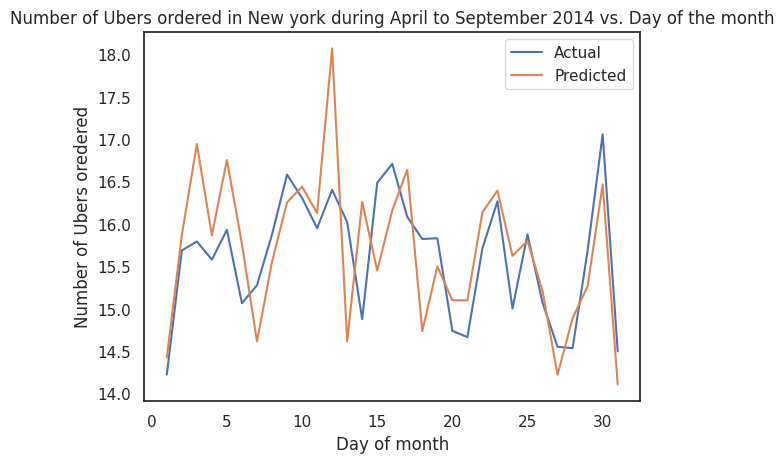

In [ ]:
plt.figure()
sns.lineplot(x = LinearData.day, y = LinearData.pickups, errorbar = None)
sns.lineplot(x = CorrectDays, y = PredictedRequirements, errorbar = None)
plt.title("Number of Ubers ordered in New york during April to September 2014 vs. Day of the month")
plt.xlabel("Day of month")
plt.ylabel("Number of Ubers oredered")
plt.legend(['Actual', 'Predicted'])
plt.show()

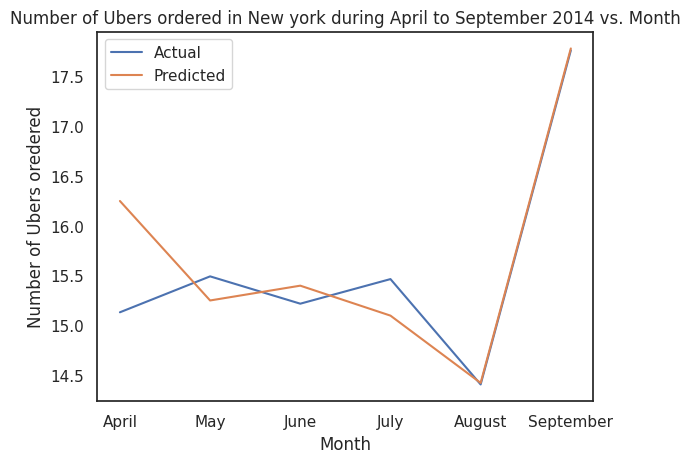

In [ ]:
plt.figure()
sns.lineplot(x = LinearData.month.replace({0: 'April', 1: 'May', 2: 'June', 3: 'July', 4: 'August', 5: 'September'}),
             y = LinearData.pickups, errorbar = None)
sns.lineplot(x = CorrectMonths, y = PredictedRequirements, errorbar = None)
plt.title("Number of Ubers ordered in New york during April to September 2014 vs. Month")
plt.xlabel("Month")
plt.ylabel("Number of Ubers oredered")
plt.legend(['Actual', 'Predicted'])
plt.show()